In [145]:
import os
import sys
from utilities.gcn_utills import *
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import networkx as nx
import glob
import pandas as pd
import scipy 
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.utils import convert
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


In [146]:
# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def read_graphs(file_set):
    g_list = []
    for i, file in enumerate(file_set):
        G = nx.read_gpickle(file)
        g_list.append(G)
    return g_list
    
def format_graphs(graphs, label=1):
    graph_list = []
    # Convert into pytorch geoetric dataset: Positive
    for i, x in enumerate(tqdm(graphs)):
        F = nx.convert_node_labels_to_integers(x)
        for (n1, n2, d) in F.edges(data=True):
            d.clear()
        data = convert.from_networkx(F, group_edge_attrs=None)
        data.y = torch.FloatTensor(np.array([label]))
        graph_list.append(data)
    return graph_list

def binary_acc(y_pred, y_test):
    probas = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag, probas

In [147]:
# Import the data
graph_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/graph_data'
labels_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/graph_labels'

graph_files = glob.glob(os.path.join(graph_dir_path, '*'))
graph_labels = glob.glob(os.path.join(labels_dir_path, '*'))
graph_labels = pd.read_csv(graph_labels[0])

# Create positive and negative sets
positives = []
pos_labels = []

negatives = []
neg_labels = []

for i, file in enumerate(graph_files):
    obs, label = get_label(file, graph_labels)
    
    if label == 1:
        positives.append(obs)
        pos_labels.append([1,0])
    else:
        negatives.append(obs)
        neg_labels.append([0,1])


In [148]:
# Balance the number of negatives with number of positives
negatives = np.random.choice(negatives, size=len(positives), replace=False)

In [149]:
# Read in the positives
pos_graphs = read_graphs(positives)
neg_graphs = read_graphs(negatives)


In [150]:
# Format graphs
positive_graphs = format_graphs(pos_graphs, label=1)
negative_graphs = format_graphs(neg_graphs, label=0)

100%|██████████| 5456/5456 [06:29<00:00, 14.00it/s]  


In [151]:
# Make sure number of negative graphs equal number of positives graphs
assert (len(negative_graphs) == len(positive_graphs))

In [152]:
# Combine negative and positive data
balanced_graphs = positive_graphs + negative_graphs

In [153]:
# Split into train and test
train_idx = np.random.choice(a=[False, True], size=len(balanced_graphs))
test_idx = ~train_idx

# Convert range to array 
full_idx = np.array(range(len(balanced_graphs)))

# Grab indices using Boolean array
tr_idx = full_idx[train_idx]
te_idx = full_idx[test_idx]

# Slice train and test data
train_data = [balanced_graphs[x] for x in tr_idx]
test_data = [balanced_graphs[x] for x in te_idx]



In [201]:
# Select appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        super(GCN, self).__init__()

        # Parameters
        self.num_node_features = 16
        self.num_classes = 1
        self.hidden_channels = hidden_channels

        # Layers (consider using class SAGEConv instead)
        self.conv1 = GCNConv(self.num_node_features, self.hidden_channels)
        self.linear_1 = Linear(self.hidden_channels, self.hidden_channels)
        self.linear_2 = Linear(self.hidden_channels, self.num_classes)

        # Paramteric PRelU
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
        self.prelu_3 = torch.nn.PReLU()

        # Regularization
        p = 0.5
        self.drop_out = torch.nn.Dropout(p=p)

        # Batch Normalization
        self.batch_norm_1 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_2 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_3 = torch.nn.BatchNorm1d(num_features=self.num_classes, track_running_stats=False, momentum=None)

    def forward(self, x, edge_index, batch):

        # 1.Conv block 1
        x = self.conv1(x, edge_index)
        x = self.prelu_1(x)
        
        # Feature pooling
        x = global_max_pool(x, batch)  # --> [batch_size, hidden_channels]

        # 3. Linearization
        x = self.linear_1(x)
        x = self.batch_norm_2(x)
        x = self.prelu_2(x)

        # 4. Logic outputs
        x = self.linear_2(x)
        x = self.batch_norm_3(x)
        x = self.drop_out(x)
        x = self.prelu_2(x)
        return x


cpu


In [202]:
# Build model
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(16, 16)
  (linear_1): Linear(in_features=16, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=1, bias=True)
  (prelu_1): PReLU(num_parameters=1)
  (prelu_2): PReLU(num_parameters=1)
  (prelu_3): PReLU(num_parameters=1)
  (drop_out): Dropout(p=0.8, inplace=False)
  (batch_norm_1): BatchNorm1d(16, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_2): BatchNorm1d(16, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_3): BatchNorm1d(1, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
)


In [203]:
# Configs
BATCH_SIZE = 50
EPOCHS = 50
LEARNING_RATE = 0.002

# Optimizers & Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Data-loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
all_loader  = DataLoader(balanced_graphs, batch_size=BATCH_SIZE, shuffle=False)


In [204]:
# Train loop
print("Begining training!")
model.train()
model = model.double()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for data in tqdm(train_loader): 

        # Grab inputs
        X, Y, EI  = data.x, data.y, data.edge_index
        B = data.batch
        
        # Zero the gradient
        optimizer.zero_grad()  

        # Compute model outputs
        logits = model(X, EI, B).flatten()
        probas = torch.sigmoid(logits)

        # Grab the loss and step gradients
        loss = criterion(probas, Y)  
        epoch_loss += loss.item() 

        # Backpropogate the loss
        loss.backward() 
        optimizer.step()  
    
    # Print the epochs
    print(epoch_loss)




Beginning training!


  0%|          | 0/109 [00:00<?, ?it/s]/mnt/mnemo5/sum02dean/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 109/109 [00:34<00:00,  3.16it/s]


78.54639250040054


100%|██████████| 109/109 [00:33<00:00,  3.21it/s]


78.4083297252655


100%|██████████| 109/109 [00:33<00:00,  3.23it/s]


78.05406045913696


100%|██████████| 109/109 [00:34<00:00,  3.17it/s]


78.14543759822845


100%|██████████| 109/109 [00:34<00:00,  3.17it/s]


78.33105111122131


100%|██████████| 109/109 [00:33<00:00,  3.21it/s]


78.51408588886261


100%|██████████| 109/109 [00:33<00:00,  3.22it/s]


78.35081654787064


100%|██████████| 109/109 [00:33<00:00,  3.23it/s]


78.335100710392


100%|██████████| 109/109 [00:34<00:00,  3.13it/s]


78.1021180152893


100%|██████████| 109/109 [00:37<00:00,  2.91it/s]


78.39201647043228


100%|██████████| 109/109 [00:41<00:00,  2.61it/s]


78.18025141954422


100%|██████████| 109/109 [00:42<00:00,  2.57it/s]


78.15710127353668


100%|██████████| 109/109 [00:36<00:00,  2.97it/s]


78.04002994298935


100%|██████████| 109/109 [00:40<00:00,  2.72it/s]


78.12321031093597


100%|██████████| 109/109 [00:37<00:00,  2.90it/s]


78.09819757938385


100%|██████████| 109/109 [00:38<00:00,  2.86it/s]


78.01706773042679


100%|██████████| 109/109 [00:35<00:00,  3.07it/s]


77.99423170089722


100%|██████████| 109/109 [00:35<00:00,  3.07it/s]


78.11325120925903


100%|██████████| 109/109 [00:33<00:00,  3.21it/s]


78.05429500341415


100%|██████████| 109/109 [00:39<00:00,  2.78it/s]


78.1416911482811


100%|██████████| 109/109 [00:35<00:00,  3.09it/s]


78.45173209905624


100%|██████████| 109/109 [00:35<00:00,  3.11it/s]


78.14942717552185


100%|██████████| 109/109 [00:35<00:00,  3.08it/s]


78.11808687448502


100%|██████████| 109/109 [00:34<00:00,  3.14it/s]


78.04617375135422


100%|██████████| 109/109 [00:35<00:00,  3.11it/s]


78.06484019756317


100%|██████████| 109/109 [00:35<00:00,  3.11it/s]


78.09763145446777


100%|██████████| 109/109 [00:35<00:00,  3.11it/s]


78.2158722281456


100%|██████████| 109/109 [00:34<00:00,  3.12it/s]


78.00571143627167


100%|██████████| 109/109 [00:35<00:00,  3.10it/s]


78.08367770910263


 69%|██████▉   | 75/109 [00:24<00:10,  3.12it/s]


KeyboardInterrupt: 

100%|██████████| 109/109 [00:15<00:00,  6.89it/s]


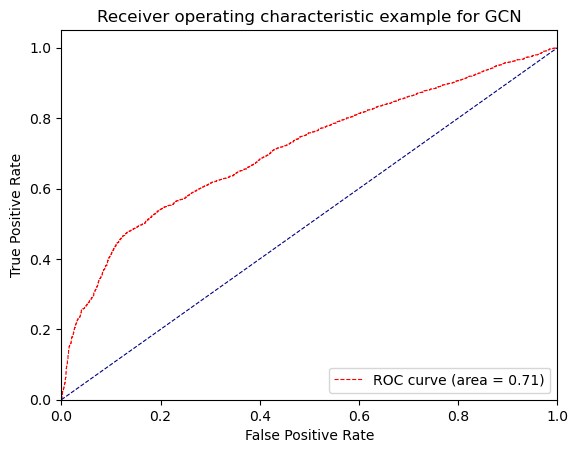

In [205]:
predictions = []
probabilities = []
truths = []

# Loadder names: train_loader, test_loader, all_loader
model.eval()
with torch.no_grad():
    for data in tqdm(train_loader): 
        
        # Grab inputs
        X, Y, EI  = data.x, data.y, data.edge_index
        B = data.batch

        # # Compute preds
        logits = model(X, EI, B).flatten()
        acc, pred, probas = binary_acc(logits, Y)

        # Append data
        predictions.append(pred)
        probabilities.append(probas)
        truths.append(Y)

# Format
p = np.hstack(predictions)
t = np.hstack(truths)
prob = np.array(torch.concat(probabilities))

# AUC/ROC
fpr, tpr, _ = roc_curve(t, prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
lw = 0.8
plt.plot(fpr, tpr, "r--", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example for GCN")
plt.legend(loc="lower right")
plt.show()
plt.show()


In [197]:
x_train = []
for data in train_loader:
    X, Y, EI, B = data.x, data.y, data.edge_index, data.batch
    x_train.append(X)
x_train = pd.DataFrame(np.vstack(x_train))


In [198]:
x_test = []
for data in test_loader:
    X, Y, EI, B = data.x, data.y, data.edge_index, data.batch
    x_test.append(X)
x_test = pd.DataFrame(np.vstack(x_test))

In [200]:
# for i in range(np.shape(x_train)[1]):
#     sns.histplot(x_train[i].values, bins=50)
#     sns.histplot(x_test[i].values, bins=50)
#     plt.show()